In [2]:
import sys, os
sys.path.append("../main")
from santa_fe_2 import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from numba import njit
from scipy.optimize import curve_fit
import pandas as pd

@njit()
def compute_diffusion_rate(vol_size,array, min_val = 1):
    variance = np.zeros(vol_size - min_val + 1)
    for i in range(min_val, vol_size+1):
        new_arr = array[i:]-array[:-i]
        variance[i - min_val] = new_arr.var()
    return variance

@njit()
def compute_volatility(vol_size,array):
    sigma = np.zeros(vol_size)
    for i in range(1,vol_size+1):
        #new_arr = ((array[i:]-array[:-i])**2).mean()
        #sigma[i] = np.sqrt((new_arr/array.mean()**2))
        sigma[i] = array[::i].std()
    return sigma

@njit()
def compute_volatility_1(vol_size,array):
    sigma = np.zeros(vol_size)
    for i in range(1,vol_size+1):
        new_arr = (array[i:]-array[:-i])**2
        sigma[i] = new_arr.sum()/i
    return sigma

def avg(lst):
    return np.array(lst).mean()

def func(x, m, q):
    return m * x + q

def find_param(xx,yy):
    popt, pcov = curve_fit(func, xx, yy)
    m = popt[0]
    q = popt[1]
    err_m = np.sqrt(pcov[0][0])
    err_q = np.sqrt(pcov[1][1])

    
    return m, q, err_m, err_q

def func(x,x0,gamma):
    return x0*x+gamma

def func2(x,x0,gamma):
    return x0*x**gamma

def find_param_vol(xx,yy,x0=10e-5,gamma=1):
    popt, pcov = curve_fit(func2, xx, yy,p0=(x0,gamma))
    xx0 = popt[0]
    gamma0 = popt[1]
    return xx0,gamma0

@njit()
def compute_price_impact(price,sign,max_lag,step=1):
    impact = []
    std_impact = []
    for i in range(1,max_lag,step):
        impact.append((sign[:-i]*(price[i:]-price[:-i])).mean())
        std_impact.append((sign[:-i]*(price[i:]-price[:-i])).std() / np.sqrt(len(price[i:])))
    
    return impact, std_impact

# Spread 

In [3]:
_, _, spread, lamb, nu, mu, _, _, volat, gts = \
    np.loadtxt("../data/santa_fe_parameter_estimation_2.txt",delimiter=",", unpack = True)

In [4]:
mean_sp = np.zeros(len(spread))
vol = np.zeros(len(spread))
gap_to_spr = np.zeros(len(spread))

i = 0
for limit, market, cancel in zip(lamb, nu, mu):
    lob, _, _, _  = simulate_lob(limit, market, cancel, 600, 500_000)
    lob = lob[100_000:]
    md, sp = find_mid_spread_lob(lob)
    mean_sp[i] = sp.mean()
    vol[i] = md.std()
    gap_to_spr[i] = find_gap(lob)/sp.mean()
    i += 1 

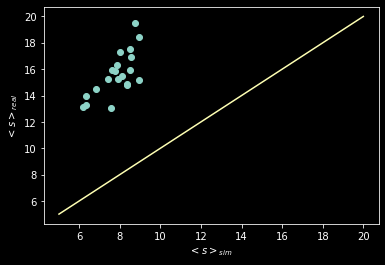

In [5]:
plt.style.use('dark_background')
xx = np.linspace(5,20,100)
plt.plot(mean_sp,spread,"o")
plt.xlabel(r"$<s>_{sim}$")
plt.ylabel(r"$<s>_{real}$")
plt.plot(xx,xx)


In [6]:
#create a list of all the files in the folder
DIR ="C:\\Users\\spina\\Documents\\SOLDI\\data\\tesla_2015\\order\\TSLA_2015-01-30_34200000_57600000_orderbook_10.csv"
header_list = ["ask price","ask vol","bid price","bid vol"]

df_order = pd.concat([pd.read_csv(DIR, names=header_list,usecols=[0,1,2,3])])
df_order.reset_index(drop=True, inplace=True)

df_order["ask price"] = df_order["ask price"]/100
df_order["bid price"] = df_order["bid price"]/100
# add spread and mid price to the dataframe
df_order["spread"] = df_order["ask price"] - df_order["bid price"]
df_order["mid price"] = (df_order["ask price"] + df_order["bid price"]) / 2

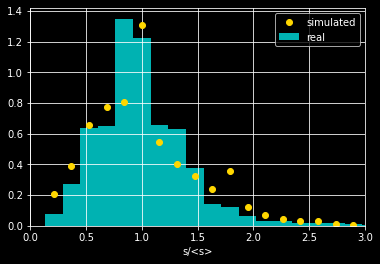

In [7]:
    n,n_bins,_ = plt.hist(sp/mean_sp[-1], density=True,bins=20, alpha=0)
    #plt.plot(n_bins + n_bins/34 , n)
    (df_order["spread"] / df_order["spread"].mean()).hist(
        bins = n_bins, density=True, color="aqua", label="real", alpha= 0.7)
    pos = (n_bins[1:] + n_bins[:-1]) / 2
    plt.plot(pos, n, "o",label = "simulated",c="gold")
    plt.xlabel("s/<s>")
    plt.xlim(0,3)
    plt.legend()
    plt.show()

# gap to spread

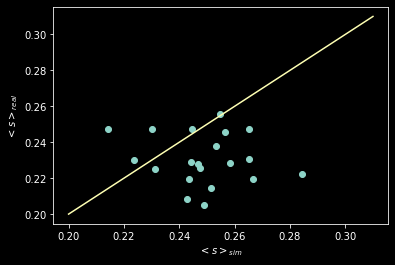

In [8]:
plt.plot(gap_to_spr,gts,"o")
plt.xlabel(r"$<s>_{sim}$")
plt.ylabel(r"$<s>_{real}$")
x = np.linspace(.20,.31,20)

plt.plot(x,x)

# gap

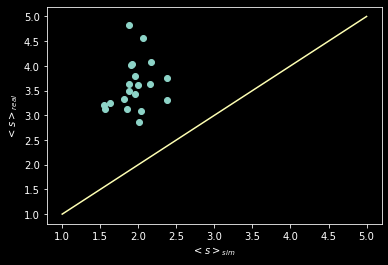

In [9]:
plt.plot(gap_to_spr * mean_sp ,gts*spread,"o")
plt.xlabel(r"$<s>_{sim}$")
plt.ylabel(r"$<s>_{real}$")
x = np.linspace(1,5,20)

plt.plot(x,x)

# volatility

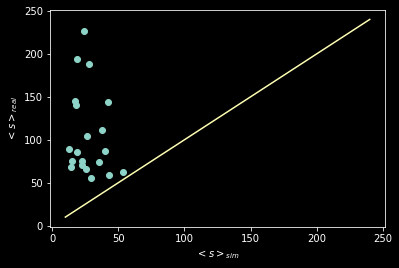

In [10]:
plt.plot(vol,volat,"o")
x1 = np.linspace(10,240,10)
plt.xlabel(r"$<s>_{sim}$")
plt.ylabel(r"$<s>_{real}$")
plt.plot(x1,x1)

# Market impact

In [11]:
rate_lim = 0.030436
rate_m   = 0.047497
rate_del = 0.121010

impact = np.zeros((100,50))
for i in range(100):
    print(i, end="\r")
    lob, o_type, sign, price = simulate_lob(rate_lim, rate_m, rate_del, 1000,1000_000)
    md, sp = find_mid_spread_lob(lob)

    stats = dict()
    stats["order type"] = np.array(o_type)
    stats["price"] = np.array(price)
    stats["direction"] = np.array(sign)
    stats["spread"] = sp[:-1]
    stats["mid price"] = md[:-1]
    df = pd.DataFrame(stats)
    df.drop(labels = 0, axis = 0, inplace = True)
    market_df = df[df["order type"] == 1]
    market_orders = market_df.index.to_numpy() - 2
    sign_orders = market_df["direction"].to_numpy()
    new_df = df.iloc[market_orders]
    mid_p = new_df["mid price"].to_numpy()
    p_impact, std_p = compute_price_impact(mid_p,sign_orders,51)
    impact[i,:] = p_impact

In [19]:
m_impact = np.zeros(50)
err_impact = np.zeros(50)

for i in range(50):
    m_impact[i] = impact[:,i].mean()
    err_impact[i] = impact[:,i].std()

(0.0, 3.0)

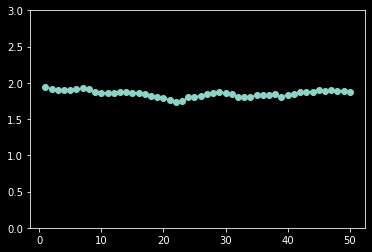

In [24]:
x = np.arange(1,51)
plt.errorbar(x,m_impact,marker="o")
plt.ylim(0,3)

In [16]:
impact[:,2]

array([2.5187747 , 1.94936306, 1.92820348, 2.5       , 1.89265358,
       1.31425891, 1.20976658, 1.79295426, 1.44026683, 1.67159167,
       2.04565353, 1.93376623, 1.89829438, 1.97565789, 1.67411924,
       1.77420362, 2.3298009 , 1.95602294, 1.40555201, 2.20408163,
       2.26649746, 1.45930233, 1.81664541, 1.80136561, 1.66037736,
       1.95844595, 2.13341969, 1.67426108, 1.93352601, 1.80673077,
       2.13541004, 2.26204239, 2.217     , 1.57803468, 1.75      ,
       1.92796885, 2.2989418 , 2.14560261, 1.8152662 , 1.71358589,
       1.82868904, 2.16006289, 1.70087065, 1.70109748, 2.00219573,
       1.13607189, 1.64977258, 1.86722798, 1.97155785, 1.87341349,
       2.23371284, 1.24301494, 1.67898833, 1.86996099, 1.7616168 ,
       2.31465247, 2.33601984, 1.92894057, 1.69352792, 2.65750323,
       1.63221306, 2.02063599, 1.27718078, 1.34095494, 1.8601071 ,
       1.7482737 , 2.40153945, 1.67791971, 1.99967256, 2.00290135,
       1.88690096, 1.6045108 , 1.93497475, 2.49425676, 2.25128